In [3]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [4]:
#l_data/LC81220342016070LGN00_toa_band1.tif
#g.GetGeoTransform()
#(-0.0625, 0.125, 0.0, 90.0625, 0.0, -0.125)
#CA	15.98	434.97	450.95	442.96
#Blue	60.04	452.02	512.06	482.04
#Green	57.33	532.74	590.07	561.41
#Red	37.47	635.85	673.32	654.59
#NIR	28.25	850.54	878.79	864.67
#SWIR1	84.72	1566.50	1651.22	1608.86
#SWIR2	186.66	2107.40	2294.06	2200.73

In [ ]:
import gdal
import glob 
import gdal
import numpy as np
import numpy.ma as ma
import sys
sys.path.insert(0, 'python')
#import kernels
from geo_trans import *
from readSent import *
import pylab as plt
%matplotlib inline
from scipy.interpolate import griddata
from Dload_Finder import *
from fft_helper import *
from get_brdf1 import *
from nicer_plot import *
from linear_plot7 import *
from L_geo import *
from scipy import ndimage, signal
import geocoder
from Py6S import *
from scipy import optimize
from fastRWpkl import *
from smoothn import *
from scipy import signal

In [5]:
plot_config()

/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
#l_data/LC81220342016070LGN00_toa_band

In [7]:
lat, lon, year = 37.474469, 117.346456, 2016
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']
Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))

In [8]:
doys = [int(i.split('2016')[1][:3]) for i in Hfiles]
doy = doys[1]; Hsat = 'L'

Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(path, row, year, doy)
Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]

In [9]:
with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
    for line in inF:
        if 'CLOUD_COVER ' in line:
            cloud_cover =  float(line.split('= ')[1])
if cloud_cover<20:
    print 'Less than 20% cloud.'
    b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
    corners = b1.shape

    cloud = gdal.Open(Hfile[:-4]+'_cfmask.tif').ReadAsArray()
    cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0

    dic = {}

    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif 'ROLL_ANGLE' in line:
                vza = float(line.split(' = ')[1])
            elif 'SUN_AZIMUTH' in line:
                saa = float(line.split(' = ')[1])
            elif 'SUN_ELEVATION' in line:
                sza = float(line.split(' = ')[1])
    with open('Landsat_azm.pkl', 'r') as savefile:
        Landsat_azm = pkl.load(savefile)

    lazm = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
    raa = lazm-saa

    L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)

    tems = np.zeros((3,6))
    tems[0,:] = sza
    tems[1,:] = vza
    tems[2,:] = raa
    #brdfs, qa = get_brdf_six(Lfile, (tems[0], tems[1], tems[2]), bands=[3,4,1,2,6,7])

Less than 20% cloud.


In [10]:
Lx, Ly = L_inds
Hx, Hy = H_inds
L_inds, H_inds

((array([354, 354, 354, ..., 864, 864, 864]),
  array([ 188,  189,  190, ..., 1316, 1317, 1318])),
 array([[  10,   10,   10, ..., 7842, 7842, 7842],
        [   1,   17,   32, ..., 7655, 7671, 7686]]))

In [15]:
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)

In [ ]:
temp = 'l_data/LC81220342016070LGN00_toa_band%s.tif' 
Land_data = np.array([gdal.Open(temp%band).ReadAsArray()*0.0001 for band in [2,3,4,5,6,7]])

In [ ]:
Land_mask = np.zeros_like(Land_data).astype('bool')
for i,data in enumerate(Land_data):
    mask = ~(data<0).astype('bool')
    small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
    val_mask = (~dia_cloud)&small_mask
    Land_mask[i] = val_mask

In [ ]:
qa_mask = qa<1

In [ ]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

In [ ]:
xwin,ywin = 40,40
xs, ys = 32.69694328,   4.44815254
xstd,ystd,angle = 6.9750168 ,  32.69694328, 4.44815254
ker = gaussian(xwin,ywin,xstd,ystd,angle,True)  
#ker = G/(G.sum())
to_regs = []
for index, H_data in enumerate(Land_data):
    s1, s2 = np.array(H_data.shape), np.array([40,40]) # Gasussian size
    shape = s1 + s2 - 1
    fshape = [next_fast_len(int(i)) for i in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    sp1 = np.fft.rfftn(H_data, fshape)
    sp2 = np.fft.rfftn(ker, fshape)
    ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice])
    ss = centered(ret, s1)
    #s = signal.fftconvolve(H_data, ker, mode='same')
    # remove the cloud pixel
    ss[~Land_mask[index,:,:]]=np.nan
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals = brdfs[index][Lx[val], Ly[val]]*0.001, ss[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)&(qa_mask[index][Lx[val], Ly[val]])
    to_regs.append( [Lvals[mas], Hvals[mas]])

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


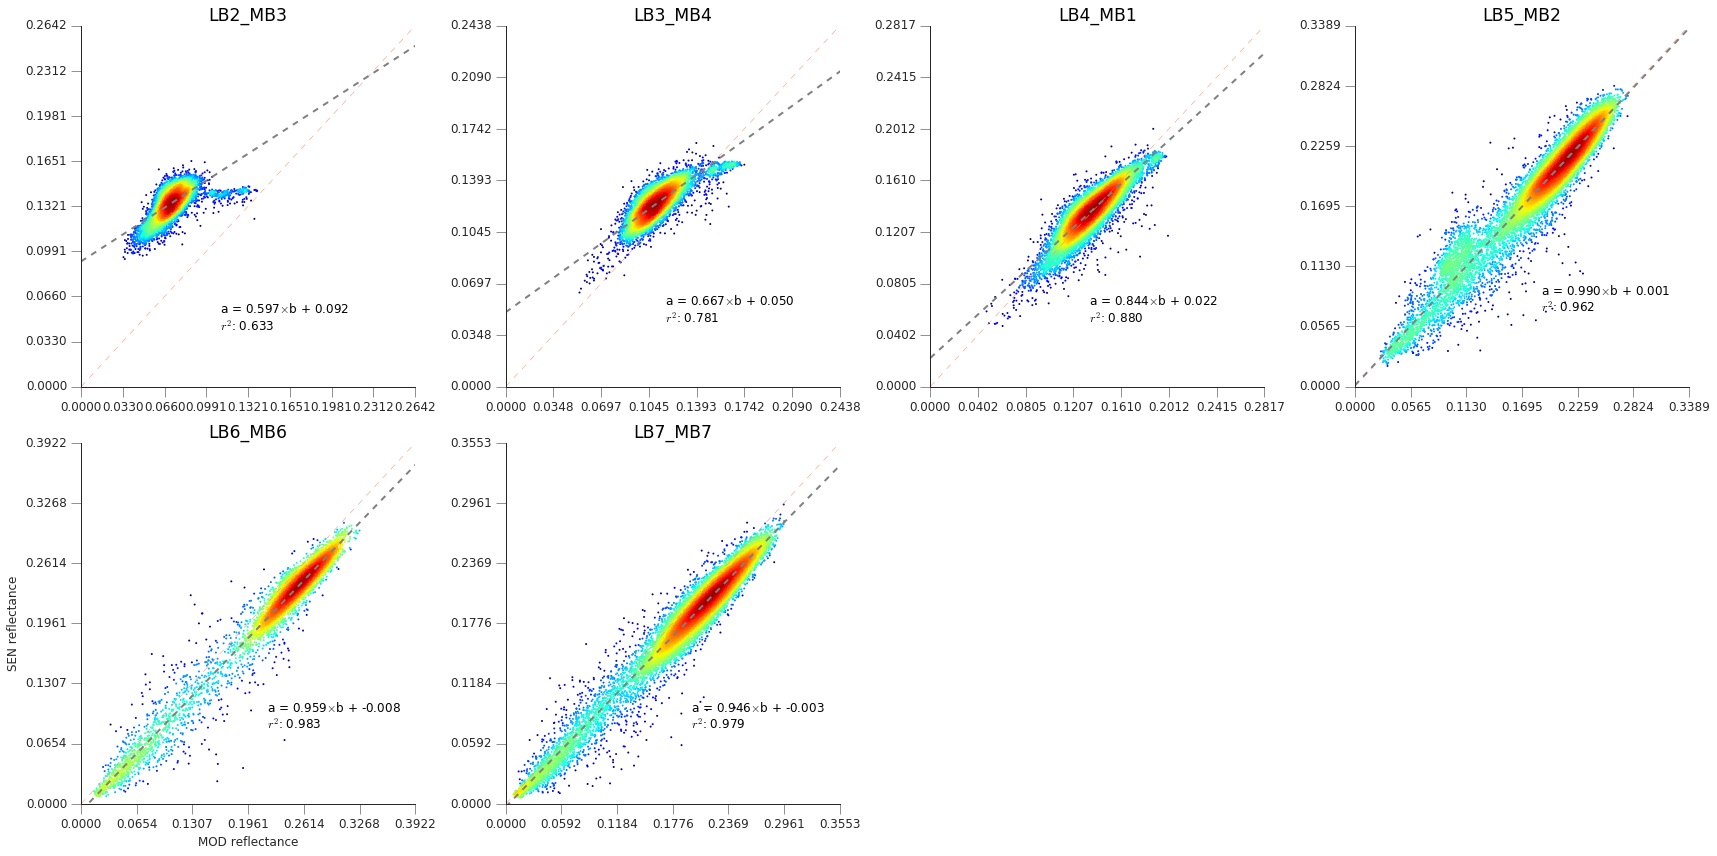

In [65]:
ldata = [i[0] for i in to_regs]
hdata = [i[1] for i in to_regs]
linear_plots(ldata, hdata, cmap=plt.cm.get_cmap('jet'), 
             titles=['LB2_MB3','LB3_MB4','LB4_MB1','LB5_MB2','LB6_MB6', 'LB7_MB7'], three_sigma=0)
plt.savefig('Land_TOA_regs.pdf')

In [ ]:
path_rad = []
trans = []
for i in to_regs:
    r = scipy.stats.linregress(i[0], i[1])
    path_rad.append( r.intercept) 
    trans.append(r.slope)

In [9]:
path_rad = [0.092,0.050,0.022,0.001, -0.008, -0.003]
trans = [0.597, 0.667, 0.844, 0.990, 0.959, 0.946]

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


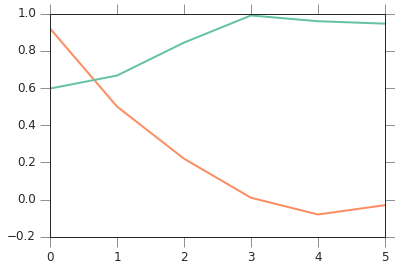

In [10]:
plt.plot(np.array(path_rad)*10)
plt.plot(np.array(trans))

In [17]:
g = geocoder.elevation((lat, lon))
ele = g.meters/1000.
ele

0.0119

In [18]:
angles = sza, saa, vza, lazm

In [19]:
rsr = PredefinedWavelengths.LANDSAT_OLI_B2,PredefinedWavelengths.LANDSAT_OLI_B3,PredefinedWavelengths.LANDSAT_OLI_B4, PredefinedWavelengths.LANDSAT_OLI_B5, PredefinedWavelengths.LANDSAT_OLI_B6, PredefinedWavelengths.LANDSAT_OLI_B7
def cost(aot):
    tts = []
    prs = []
    for i in range(6):       
        path = '/home/ucfafyi/DATA/Downloads/6SV2.1/sixsV2.1'
        s = SixS(path)
        s.altitudes.set_target_custom_altitude(ele)
        s.altitudes.set_sensor_satellite_level()# sentinel 2 
        s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
        s.geometry = Geometry.User()
        s.geometry.solar_a = saa
        s.geometry.solar_z = sza
        s.geometry.view_a = lazm
        s.geometry.view_z = vza
        s.wavelength = Wavelength(rsr[i])
        s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)
        s.aot550 = aot
        s.atmos_profile = AtmosProfile.UserWaterAndOzone(0.20407022361175747,  0.40960163297380831)
        s.run()
        tt = s.outputs.transmittance_total_scattering.total
        pr = s.outputs.atmospheric_intrinsic_reflectance
        tts.append(tt)
        prs.append(pr)
    
    cos = np.abs(np.array(trans) - np.array(tts))+np.abs(np.array(path_rad) - np.array(prs))
    print aot, cos.sum()
    return cos.sum()

In [20]:
retval = optimize.fmin(cost, np.array([0.25,]), full_output=1)

[ 0.25] 0.39328
[ 0.2625] 0.3918
[ 0.275] 0.38833
[ 0.2875] 0.38792
[ 0.3125] 0.39128
[ 0.3] 0.38733
[ 0.3125] 0.39128
[ 0.29375] 0.38821
[ 0.29375] 0.38821
[ 0.30625] 0.38781
[ 0.303125] 0.38708
[ 0.30625] 0.38781
[ 0.3015625] 0.38716
[ 0.3046875] 0.38745
[ 0.30234375] 0.38707
[ 0.3015625] 0.38716
[ 0.30273438] 0.38703
[ 0.303125] 0.38708
[ 0.30253906] 0.38706
[ 0.30292969] 0.38704
[ 0.30283203] 0.38701
Optimization terminated successfully.
         Current function value: 0.387010
         Iterations: 10
         Function evaluations: 21


In [21]:
retval

(array([ 0.30283203]), 0.38700999999999997, 10, 21, 0)

In [14]:
Mcomb_mask = np.all(qa<2, axis=0)
Lcomb_mask = np.all(Land_mask, axis = 0)

In [15]:
xwin,ywin = 40,40
xs, ys = 32.69694328,   4.44815254
xstd,ystd,angle = 6.9750168 ,  32.69694328, 4.44815254
ker = gaussian(xwin,ywin,xstd,ystd,angle,True)  
#ker = G/(G.sum())
to_corr = []
for index, H_data in enumerate(Land_data):
    s1, s2 = np.array(H_data.shape), np.array([40,40]) # Gasussian size
    shape = s1 + s2 - 1
    fshape = [next_fast_len(int(i)) for i in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    sp1 = np.fft.rfftn(H_data, fshape)
    sp2 = np.fft.rfftn(ker, fshape)
    ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice])
    ss = centered(ret, s1)
    #s = signal.fftconvolve(H_data, ker, mode='same')
    # remove the cloud pixel
    ss[~Lcomb_mask]=np.nan
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals = brdfs[index,Lx[val], Ly[val]]*0.001, ss[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)&(Mcomb_mask[Lx[val], Ly[val]])
    to_corr.append([Lx[val][mas], Ly[val][mas], Lvals[mas], Hvals[mas]])

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less


In [16]:
Mcomb_mask = np.all(qa<2, axis=0)
Lcomb_mask = np.all(Land_mask, axis = 0)

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


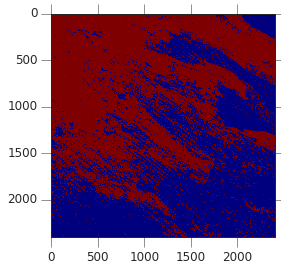

In [16]:
plt.imshow(Mcomb_mask)

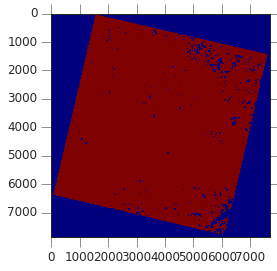

In [17]:
plt.imshow(Lcomb_mask)

In [17]:
xwin,ywin = 40,40
xs, ys = 32.69694328,   4.44815254
xstd,ystd,angle = 6.9750168 ,  32.69694328, 4.44815254
ker = gaussian(xwin,ywin,xstd,ystd,angle,True)  
to_cor=[]
Hs = np.zeros_like(Land_data)
for index, H_data in enumerate(Land_data):
    s1, s2 = np.array(H_data.shape), np.array([40,40]) # Gasussian size
    shape = s1 + s2 - 1
    fshape = [next_fast_len(int(i)) for i in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    sp1 = np.fft.rfftn(H_data, fshape)
    sp2 = np.fft.rfftn(ker, fshape)
    ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice])
    ss = centered(ret, s1)
    ss[~Lcomb_mask]=np.nan
    Hs[index] = ss

In [18]:
val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
Lvals, Hvals = brdfs[:,Lx[val], Ly[val]]*0.001, Hs[:,shx[val], shy[val]]
mas = np.all((Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1), axis=0)&(Mcomb_mask[Lx[val], Ly[val]])
to_cor = Hx[val][mas], Hy[val][mas], Lvals[:,mas], Hvals[:,mas]

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


In [45]:
def atm(p, TOA_ref = None, RSR = None, angles = None, this_lat=None, this_lon=None):
    aot550, water, ozone = p
    sz,sa, vz, va = angles
    g = geocoder.elevation((this_lat, this_lon))
    ele = g.meters/1000.
    path = '/home/ucfafyi/DATA/Downloads/6SV2.1/sixsV2.1'
    s = SixS(path)
    ss = []
    s = SixS(path)
    s.altitudes.set_target_custom_altitude(ele)
    s.altitudes.set_sensor_satellite_level()
    s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
    s.geometry = Geometry.User()
    s.geometry.solar_a = sa
    s.geometry.solar_z = sz
    s.geometry.view_a = va
    s.geometry.view_z = vz
    s.wavelength = Wavelength(RSR)
    s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)
    s.aot550 = aot550
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(water, ozone)
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(TOA_ref)
    s.run()
    return s.outputs.atmos_corrected_reflectance_lambertian

def cost(p, args = None):
    if any(p>10) or any(p<0):
        return 10000
    else:
        TOA_refs, M_refs, RSRs , angles, this_lat, this_lon = args
        Sur_refs = []
        for i in range(len(RSRs)): 
            RSR = RSRs[i]
            ss = atm(p, TOA_ref = TOA_refs[i] , RSR = RSR, angles = angles, this_lat=this_lat, this_lon=this_lon)
            Sur_refs.append(ss)
        Sur_refs = np.array(Sur_refs)
        M_refs = np.array(M_refs)
        cost = sum(abs(M_refs-Sur_refs)*w)
        
        return cost


def opt(ind):
    
    #sent_refs, modis_refs = np.array([refs[ii][tuple(aoi[ind])] for ii in range(7)]).T
    
    TOA_refs = target[3][:,ind]
    M_refs = target[2][:,ind]
    
    this_lat, this_lon = cor_inter(np.array([[target[0][ind], target[1][ind]],]).T, dic, corners)
    
    angles = sza, saa, vza, lazm
    args = TOA_refs, M_refs, RSRs , angles, this_lat, this_lon
    p = 0.30283203, 0.20407022361175747,  0.40960163297380831
    psolve = optimize.fmin(cost,p, full_output=1, args=(args,))
    print psolve
    return [target[0][ind],target[1][ind],psolve]

wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
# Problem with the LANDSAT8 RSRs
RSRs = [PredefinedWavelengths.LANDSAT_OLI_B2,PredefinedWavelengths.LANDSAT_OLI_B3,PredefinedWavelengths.LANDSAT_OLI_B4, PredefinedWavelengths.LANDSAT_OLI_B5, PredefinedWavelengths.LANDSAT_OLI_B6, PredefinedWavelengths.LANDSAT_OLI_B7]

In [22]:
x, y = geo_inter([[lat, lon],], dic, corners)
# 100 * 100 pixels
lx, rx, ly, ry = x-50, x+50, y-50, y+50
within = (to_cor[0]>lx)&(to_cor[0]<rx)&(to_cor[1]>ly)&(to_cor[1]<ry)
target = to_cor[0][within],to_cor[1][within],to_cor[2][:,within], to_cor[3][:,within]

In [45]:
x, y = geo_inter([[lat, lon],], dic, corners)
x,y

(3881, 3808)

In [23]:
parallel_rw_pkl(target, 'target', 'w')

Length of data: 4
Length of data: 4


In [11]:
target = parallel_rw_pkl(None, 'target', 'r')

In [12]:
wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000#bands
alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)

In [ ]:
pool = multiprocessing.Pool(processes=32)
retval = pool.map(opt, range(len(target[0])))
pool.close()
pool.join()

In [13]:
retval

[[3833,
  3761,
  (array([ 0.13623338,  0.22336944,  0.54466234]),
   0.0068219856928226231,
   42,
   86,
   0)],
 [3833,
  3776,
  (array([ 0.1386484 ,  0.22602144,  0.58518799]),
   0.0063815289541622987,
   51,
   107,
   0)],
 [3833,
  3791,
  (array([ 0.1752194 ,  0.22761059,  0.48658208]),
   0.0037029346835742924,
   49,
   98,
   0)],
 [3833,
  3807,
  (array([ 0.17408653,  0.22812431,  0.48700218]),
   0.0028539424714837322,
   42,
   83,
   0)],
 [3833,
  3822,
  (array([ 0.19908887,  0.21618101,  0.50628528]),
   0.0058437914392777757,
   39,
   84,
   0)],
 [3833,
  3838,
  (array([ 0.1952813 ,  0.20675723,  0.48188611]),
   0.0075918110014180432,
   41,
   84,
   0)],
 [3833,
  3853,
  (array([ 0.19427728,  0.24386104,  0.38932368]),
   0.015104459688415601,
   48,
   95,
   0)],
 [3849,
  3772,
  (array([ 0.10165603,  0.21903312,  0.58255182]),
   0.0056104126269718464,
   51,
   102,
   0)],
 [3849,
  3788,
  (array([ 0.15544961,  0.16040594,  0.66890844]),
   0.0088393

In [82]:
parallel_rw_pkl(retval, 'Landsat_aot', 'w')

Length of data: 44
Length of data: 35


In [13]:
retval = parallel_rw_pkl(None, 'Landsat_aot', 'r')

In [14]:
target[3]

array([[ 0.1280118 ,  0.12684993,  0.12911734,  0.13023702,  0.13145308,
         0.13296039,  0.13378454,  0.12932135,  0.12863367,  0.12985299,
         0.13161164,  0.13214779,  0.13060577,  0.13167261,  0.13088151,
         0.13108785,  0.13206658,  0.13081172,  0.12984584,  0.13211619,
         0.13230775,  0.13247891,  0.13333999,  0.1334298 ,  0.1330775 ,
         0.1322837 ,  0.13078098,  0.1310927 ,  0.13053938,  0.13022324,
         0.13032448,  0.13003746,  0.1304682 ,  0.12939963,  0.12946332,
         0.12773575,  0.12918952,  0.13038773,  0.13107163,  0.12956098,
         0.12836137,  0.12559153,  0.12832499,  0.1309731 ],
       [ 0.11653032,  0.11431104,  0.11644755,  0.11860239,  0.12092027,
         0.12498851,  0.12714933,  0.1174334 ,  0.11738583,  0.11874053,
         0.12158857,  0.1227672 ,  0.12138572,  0.12158313,  0.1213636 ,
         0.12186131,  0.12208687,  0.11968737,  0.11884945,  0.12097918,
         0.1207589 ,  0.12202103,  0.12363169,  0.12235599,  0.

In [15]:
retval

[[3833,
  3761,
  (array([ 0.13623338,  0.22336944,  0.54466234]),
   0.0068219856928226231,
   42,
   86,
   0)],
 [3833,
  3776,
  (array([ 0.1386484 ,  0.22602144,  0.58518799]),
   0.0063815289541622987,
   51,
   107,
   0)],
 [3833,
  3791,
  (array([ 0.1752194 ,  0.22761059,  0.48658208]),
   0.0037029346835742924,
   49,
   98,
   0)],
 [3833,
  3807,
  (array([ 0.17408653,  0.22812431,  0.48700218]),
   0.0028539424714837322,
   42,
   83,
   0)],
 [3833,
  3822,
  (array([ 0.19908887,  0.21618101,  0.50628528]),
   0.0058437914392777757,
   39,
   84,
   0)],
 [3833,
  3838,
  (array([ 0.1952813 ,  0.20675723,  0.48188611]),
   0.0075918110014180432,
   41,
   84,
   0)],
 [3833,
  3853,
  (array([ 0.19427728,  0.24386104,  0.38932368]),
   0.015104459688415601,
   48,
   95,
   0)],
 [3849,
  3772,
  (array([ 0.10165603,  0.21903312,  0.58255182]),
   0.0056104126269718464,
   51,
   102,
   0)],
 [3849,
  3788,
  (array([ 0.15544961,  0.16040594,  0.66890844]),
   0.0088393

In [16]:
indexs = [[i[0],i[1]]  for i in retval]
aot = [i[2][0][0] for i in retval]
wv = [i[2][0][1] for i in retval]
ozone = [i[2][0][2] for i in retval]

In [17]:
indexs = np.array(indexs)

(0.17382546907996582, 0.032593904942682682)

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


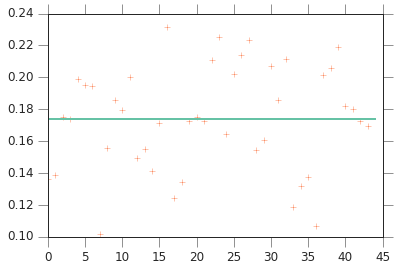

In [18]:
plt.plot(np.array(aot), '+')
plt.plot([0, len(np.array(aot))],[np.array(aot).mean(), np.array(aot).mean()])
np.array(aot).mean(), np.array(aot).std()

In [19]:
aotmap = np.zeros((110,100))

In [20]:
aotmap[:,:] = np.array(aot).mean()
aotmap[indexs[:,0]-3881, indexs[:,1]-3808] = aot

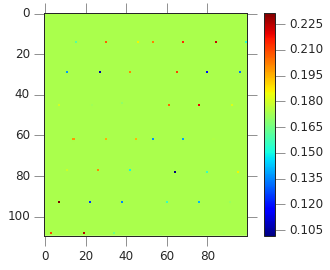

In [21]:
plt.imshow(aotmap, interpolation='None')
plt.colorbar()

In [22]:
w = np.zeros_like(aotmap)
w[indexs[:,0]-3881, indexs[:,1]-3808] = 1

In [23]:
aot_smoothed = smoothn(aotmap, W=w, isrobust=True, s=10)

python/smoothn.py:193: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if W != None:
python/smoothn.py:211: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if W == None:


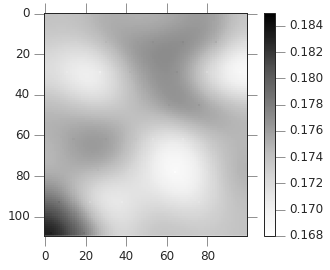

In [24]:
plt.imshow(aot_smoothed[0], interpolation='None',cmap = plt.cm.get_cmap('Greys'), vmin=0.168, vmax = 0.185)
plt.colorbar()

0.021789656839174148

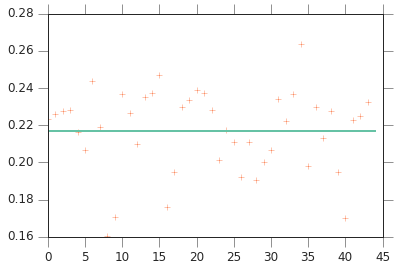

In [26]:
plt.plot(np.array(wv), '+')
plt.plot([0, len(np.array(wv))],[np.array(wv).mean(), np.array(wv).mean()])
np.array(wv).std()

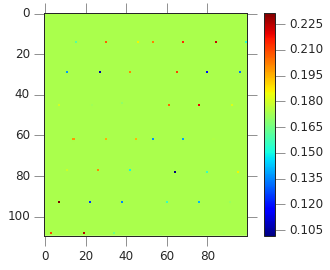

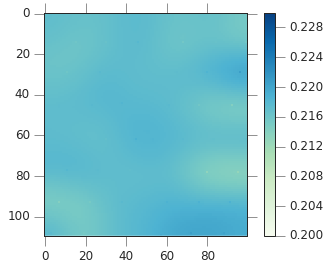

In [27]:
wvmap = np.zeros((110,100))
wvmap[:,:] = np.array(wv).mean()
wvmap[indexs[:,0]-3881, indexs[:,1]-3808] = wv
plt.figure()
plt.imshow(aotmap, interpolation='None')
plt.colorbar()

w = np.zeros_like(wvmap)
w[indexs[:,0]-3881, indexs[:,1]-3808] = 1
wv_smoothed = smoothn(wvmap, W=w, isrobust=True, s=10)
plt.figure()
plt.imshow(wv_smoothed[0], interpolation='None',cmap = plt.cm.get_cmap('GnBu'), vmin=0.2, vmax=0.23)
plt.colorbar()

0.05772201596306567

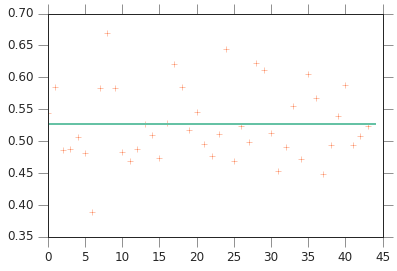

In [28]:
plt.plot(np.array(ozone), '+')
plt.plot([0, len(np.array(ozone))],[np.array(ozone).mean(), np.array(ozone).mean()])
np.array(ozone).std()

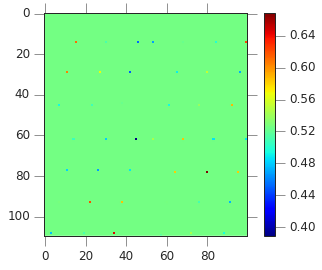

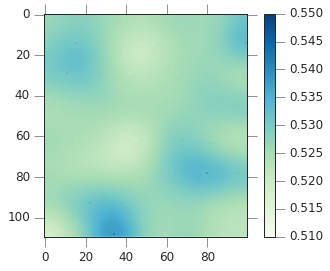

In [29]:
ozonemap = np.zeros((110,100))
ozonemap[:,:] = np.array(ozone).mean()
ozonemap[indexs[:,0]-3881, indexs[:,1]-3808] = ozone
plt.figure()
plt.imshow(ozonemap, interpolation='None')
plt.colorbar()

w = np.zeros_like(ozonemap)
w[indexs[:,0]-3881, indexs[:,1]-3808] = 1
ozone_smoothed = smoothn(ozonemap, W=w, isrobust=True, s=10)
plt.figure()
plt.imshow(ozone_smoothed[0], interpolation='None',cmap = plt.cm.get_cmap('GnBu'), vmin=0.51, vmax=0.55)
plt.colorbar()

In [42]:
sz, sa, vz, va = sza, saa, vza, lazm
def correction(ind):
    TOA_refs = Toa_ref[:,ind]
    #M_refs = target[2][:,ind]
    
    this_lat, this_lon = cor_inter(np.array([[target[0][ind], target[1][ind]],]).T, dic, corners)
    
    angles = sz, sa, vz, va
    #args = TOA_refs, M_refs, RSRs , angles, this_lat, this_lon
    #TOA_refs, M_refs, RSRs , angles, this_lat, this_lon = args
    Sur_refs = []
    aot = aots[ind]
    water = wvs[ind]
    ozone = ozones[ind]
    p = aot, water, ozone
    for i in range(len(RSRs)): 
        RSR = RSRs[i]
        ss = atm(p, TOA_ref = TOA_refs[i] , RSR = RSR, angles = angles, this_lat=this_lat, this_lon=this_lon)
        Sur_refs.append(ss)
    #Sur_refs = np.array(Sur_refs)
    return [target[0][ind], target[1][ind]] + Sur_refs

In [43]:
aots = aot_smoothed[0][indexs[:,0]-3881, indexs[:,1]-3808]
wvs = wv_smoothed[0][indexs[:,0]-3881, indexs[:,1]-3808]
ozones = ozone_smoothed[0][indexs[:,0]-3881, indexs[:,1]-3808]

In [46]:
pool = multiprocessing.Pool(processes=32)
retval = pool.map(correction, range(len(target[0])))
pool.close()
pool.join()

In [47]:
retval

[[3833, 3761, 0.07666, 0.12348, 0.15295, 0.23844, 0.26735, 0.23554],
 [3833, 3776, 0.07094, 0.11357, 0.13881, 0.25946, 0.26018, 0.21594],
 [3833, 3791, 0.07262, 0.11396, 0.14061, 0.25067, 0.27502, 0.23365],
 [3833, 3807, 0.08834, 0.12138, 0.15985, 0.21213, 0.26468, 0.24935],
 [3833, 3822, 0.07088, 0.11346, 0.13182, 0.25407, 0.2535, 0.21434],
 [3833, 3838, 0.07234, 0.11279, 0.1388, 0.24439, 0.26173, 0.22044],
 [3833, 3853, 0.05972, 0.08586, 0.11095, 0.19062, 0.22638, 0.19262],
 [3849, 3772, 0.06883, 0.10587, 0.12414, 0.23798, 0.2477, 0.20921],
 [3849, 3788, 0.08298, 0.12135, 0.14808, 0.21948, 0.2667, 0.2394],
 [3849, 3803, 0.07575, 0.1138, 0.14771, 0.21523, 0.25463, 0.22527],
 [3848, 3819, 0.07269, 0.11278, 0.13704, 0.24765, 0.26362, 0.22575],
 [3848, 3834, 0.0685, 0.10788, 0.12727, 0.24709, 0.25453, 0.21442],
 [3848, 3850, 0.09463, 0.14345, 0.18142, 0.24826, 0.31487, 0.29242],
 [3864, 3768, 0.05142, 0.08548, 0.09935, 0.22811, 0.20374, 0.15194],
 [3864, 3784, 0.05139, 0.07042, 0.08785, 

In [48]:
target[3]

array([[ 0.1280118 ,  0.12684993,  0.12911734,  0.13023702,  0.13145308,
         0.13296039,  0.13378454,  0.12932135,  0.12863367,  0.12985299,
         0.13161164,  0.13214779,  0.13060577,  0.13167261,  0.13088151,
         0.13108785,  0.13206658,  0.13081172,  0.12984584,  0.13211619,
         0.13230775,  0.13247891,  0.13333999,  0.1334298 ,  0.1330775 ,
         0.1322837 ,  0.13078098,  0.1310927 ,  0.13053938,  0.13022324,
         0.13032448,  0.13003746,  0.1304682 ,  0.12939963,  0.12946332,
         0.12773575,  0.12918952,  0.13038773,  0.13107163,  0.12956098,
         0.12836137,  0.12559153,  0.12832499,  0.1309731 ],
       [ 0.11653032,  0.11431104,  0.11644755,  0.11860239,  0.12092027,
         0.12498851,  0.12714933,  0.1174334 ,  0.11738583,  0.11874053,
         0.12158857,  0.1227672 ,  0.12138572,  0.12158313,  0.1213636 ,
         0.12186131,  0.12208687,  0.11968737,  0.11884945,  0.12097918,
         0.1207589 ,  0.12202103,  0.12363169,  0.12235599,  0.

In [49]:
combined = np.hstack((np.array(retval), target[3].T))

In [168]:
Land_data.mean(axis=1)

array([ 0.07381136,  0.10380455,  0.12738409,  0.22792273,  0.24602955,
        0.20908409])

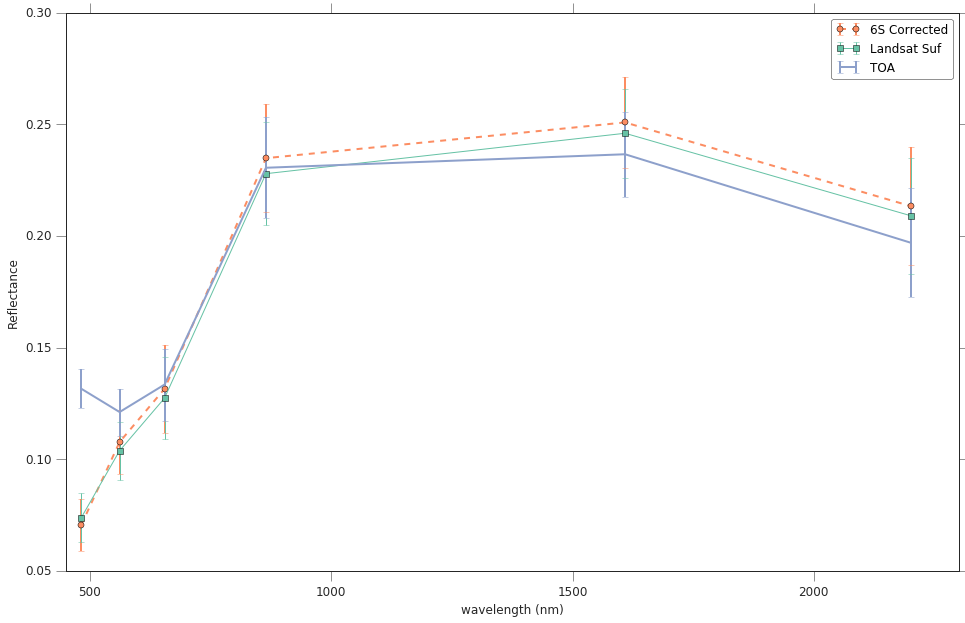

In [60]:
#plt.plot((combined[:,2:8]).mean(axis=0), )
#plt.plot(combined[:,8:].mean(axis=0), label = 'TOA')
plt.figure(figsize=(16,10))
plt.errorbar(wl*1000, (combined[:,2:8]).mean(axis=0), yerr=(combined[:,2:8]).std(axis=0), label = '6S Corrected', fmt='--o')
#plt.errorbar(wl*1000, (combined[:,8:]).mean(axis=0), yerr=(combined[:,2:8]).std(axis=0),label = 'TOA',fmt='--o')
plt.errorbar(wl*1000, Land_data.mean(axis=1), yerr=Land_data.std(axis=1),marker='s',label = 'Landsat Suf', lw=1)
plt.errorbar(wl*1000, Toa_ref.mean(axis=1), yerr=Toa_ref.std(axis=1),label = 'TOA')
plt.xlim(450,2300)
plt.legend(loc=0)
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')
plt.savefig('image/Landsat_coorection.pdf')

In [35]:
temp = 'l_data/LC81220342016070LGN00_toa_band%s.tif' 
Toa_ref = np.array([gdal.Open(temp%band).ReadAsArray()*0.0001 for band in [2,3,4,5,6,7]])[:,indexs[:,0], indexs[:,1]]

In [32]:
Land_data = np.array([gdal.Open(Hfile+'band%d.tif'%band).ReadAsArray()*0.0001 for band in [2,3,4,5,6,7]])[:,indexs[:,0], indexs[:,1]]

In [33]:
Land_data

array([[ 0.0794,  0.074 ,  0.0757,  0.0903,  0.0742,  0.0756,  0.0639,
         0.0719,  0.0851,  0.0786,  0.0759,  0.072 ,  0.096 ,  0.056 ,
         0.056 ,  0.0732,  0.0669,  0.0706,  0.0752,  0.074 ,  0.0734,
         0.0677,  0.083 ,  0.0789,  0.0656,  0.0729,  0.0722,  0.0645,
         0.0826,  0.0736,  0.066 ,  0.0651,  0.111 ,  0.0609,  0.0656,
         0.0727,  0.0979,  0.0626,  0.0669,  0.0676,  0.0867,  0.0614,
         0.063 ,  0.0814],
       [ 0.1183,  0.109 ,  0.1096,  0.1165,  0.1092,  0.1087,  0.0841,
         0.1018,  0.1159,  0.1092,  0.1086,  0.1042,  0.1367,  0.0834,
         0.0697,  0.1072,  0.0977,  0.1023,  0.1095,  0.097 ,  0.101 ,
         0.0966,  0.1125,  0.1064,  0.0955,  0.1069,  0.1039,  0.0954,
         0.1165,  0.105 ,  0.0977,  0.0947,  0.1331,  0.0841,  0.0963,
         0.1065,  0.1259,  0.0824,  0.0985,  0.0971,  0.1152,  0.0893,
         0.0913,  0.117 ],
       [ 0.1474,  0.134 ,  0.1359,  0.1538,  0.1277,  0.1343,  0.1084,
         0.1203,  0.142

In [ ]:
def atm(p,sref = None, sen_rsr = None, band = None, angles = None, lat=None, lon=None):
    aot550, water, ozone = p
    #print p
    sz,sa, vz, va = angles
    g = geocoder.elevation((lat, lon))
    ele = g.meters/1000.
    path = '/home/ucfafyi/DATA/Downloads/6SV2.1/sixsV2.1'
    s = SixS(path)

    s.altitudes.set_target_custom_altitude(ele)
    s.altitudes.set_sensor_satellite_level()# sentinel 2 
    s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
    s.geometry = Geometry.User()
    s.geometry.solar_a = sa
    s.geometry.solar_z = sz
    s.geometry.view_a = va[band]
    s.geometry.view_z = vz[band]
    srsp = sen_rsr[band]
    wv, we = swl[srsp!=0]/1000.,srsp[srsp!=0]
    mi,ma = round(wv.min(),3),round(wv.max(),3)
    f = interpolate.interp1d(wv,we)
    xnew = np.arange(mi,ma,0.0025)
    ynew = f(xnew)
    s.wavelength = Wavelength(xnew[0],xnew[-1],ynew)
    s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)
    s.aot550 = aot550
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(water, ozone)
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(sref)
    s.run()
    return s.outputs.atmos_corrected_reflectance_lambertian
